In [1]:
using DifferentialEquations
using PyPlot
using RMS

In [2]:
phaseDict = readinput("../src/testing/superminimal.yml") #load mechanism dictionary

Dict{Any,Any} with 1 entry:
  "gas" => Dict{Any,Any}("Species"=>Species[Species{NASA{EmptyThermoUncertainty…

In [3]:
spcs = phaseDict["gas"]["Species"]; #mechanism dictionaries index:  phaseDict[phasename]["Species" or "Reactions"]
rxns = phaseDict["gas"]["Reactions"];

In [4]:
ig = IdealGas(spcs,rxns,name="gas"); #Define the phase (how species thermodynamic and kinetic properties calculated)
initialconds = Dict(["T"=>1000.0,"P"=>1e5,"H2"=>0.67,"O2"=>0.33]); #Set simulation Initial Temp and Pressure
domain,y0 = ConstantTPDomain(phase=ig,initialconds=initialconds;sensitivity=true); #Define the domain (encodes how system thermodynamic properties calculated)

In [5]:
eqmols = equilibrium(ig,y0,1000.0)

12-element Array{Float64,1}:
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.010000000000000009
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.66                

In [6]:
getfield.(ig.species,:name)

12-element Array{String,1}:
 "Ar"   
 "He"   
 "Ne"   
 "N2"   
 "H2"   
 "O2"   
 "H"    
 "[O]O" 
 "OH(D)"
 "O(T)" 
 "OO"   
 "H2O"  

In [7]:
react = Reactor(domain,y0,(0.0,150.11094)); #Create the reactor object

In [8]:
sol = solve(react.ode,CVODE_BDF(),abstol=1e-20,reltol=1e-12); #solve the ode associated with the reactor

In [9]:
bsol = Simulation(sol,domain);

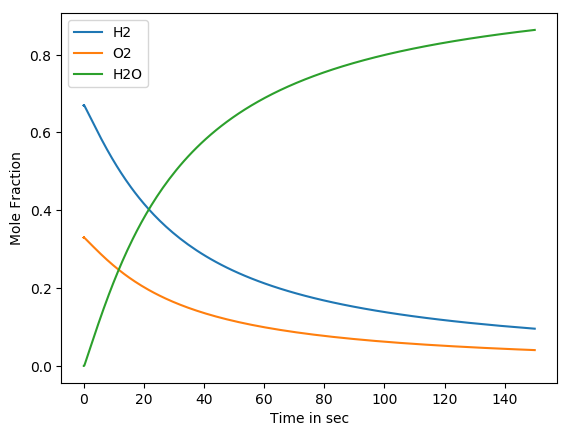

PyObject <matplotlib.text.Text object at 0x170b2a790>

In [10]:
plotmolefractions(bsol,150.0; t0=1e-15, N=1000, tol=0.01)

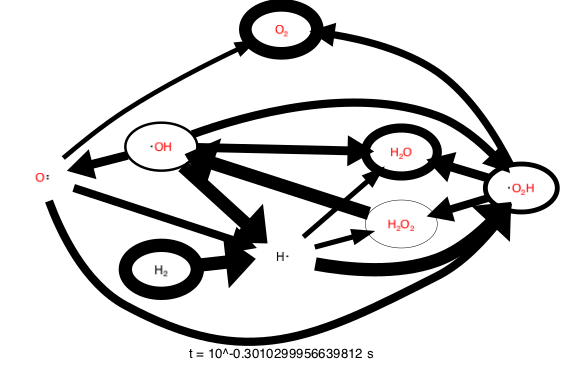

In [11]:
getfluxdiagram(bsol,0.5,centralspecieslist=["OH(D)"],radius=5)

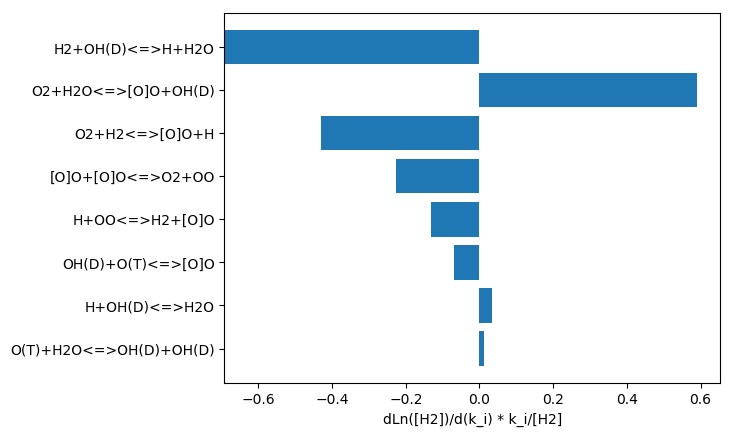

PyObject <matplotlib.text.Text object at 0x163193350>

In [12]:
plotmaxratesensitivity(bsol,"H2")